In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Importing necessary libraries 

In [74]:
root_path = 'drive/MyDrive/Colab Notebooks/data/'

In [2]:

import os
import cv2
from PIL import Image
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [12]:
names = [name.replace(' ', '_').split('_')[0] for name in os.listdir(root_path)]
classes = Counter(names)  #returns dictionary

**Data Analysis**

In [13]:
classes

Counter({'arecaceae': 35,
         'anadenanthera': 20,
         'arrabidaea': 35,
         'cecropia': 35,
         'chromolaena': 35,
         'combretum': 35,
         'croton': 35,
         'dipteryx': 35,
         'eucalipto': 35,
         'faramea': 35,
         'hyptis': 35,
         'mabea': 35,
         'matayba': 35,
         'mimosa': 35,
         'myrcia': 35,
         'protium': 35,
         'qualea': 35,
         'schinus': 35,
         'senegalia': 35,
         'serjania': 35,
         'syagrus': 35,
         'tridax': 35,
         'urochloa': 35})

In [14]:
#Total no of images
print("number of images:",len(names))


number of images: 790


In [15]:
path_class  = {key:[] for key in classes.keys()}

for name in os.listdir(root_path):
    key = name.replace(' ', '_').split('_')[0]
    path_class[key].append(root_path + name)

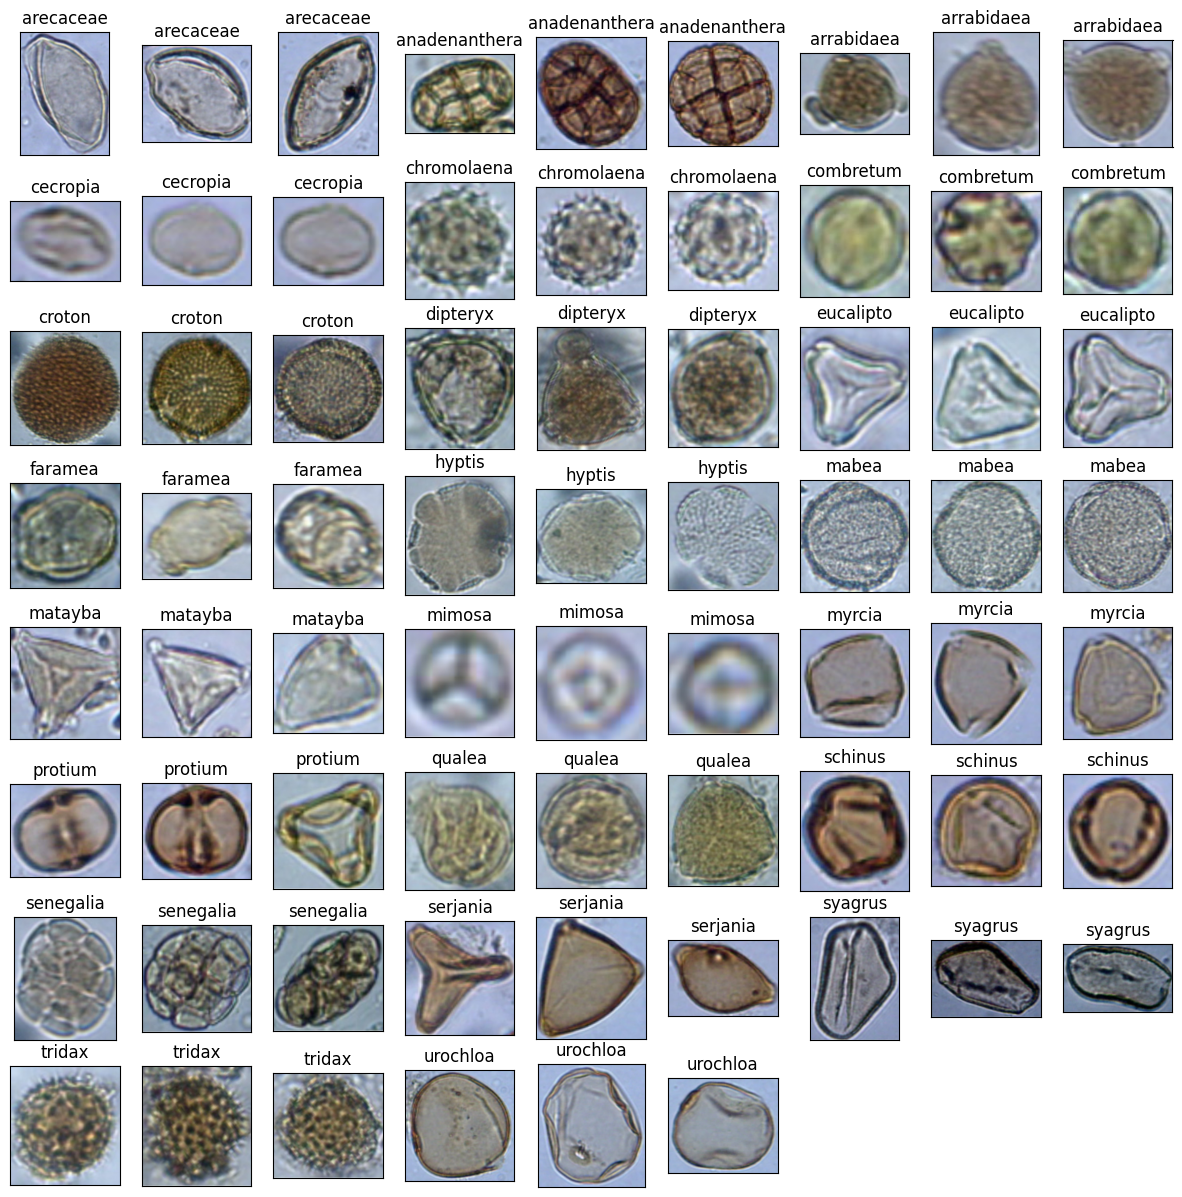

In [16]:
fig = plt.figure(figsize=(15, 15))
for i, key in enumerate(path_class.keys()):
    img1 = Image.open(path_class[key][0]) 
    img2 = Image.open(path_class[key][1]) 
    img3 = Image.open(path_class[key][2]) 

    ax = fig.add_subplot(8, 9,  3*i + 1, xticks=[], yticks=[])
    ax.imshow(img1)
    ax.set_title(key)
    
    ax = fig.add_subplot(8, 9,  3*i + 2, xticks=[], yticks=[])
    ax.imshow(img2)
    ax.set_title(key)

    ax = fig.add_subplot(8, 9,  3*i + 3, xticks=[], yticks=[])
    ax.imshow(img3)
    ax.set_title(key)

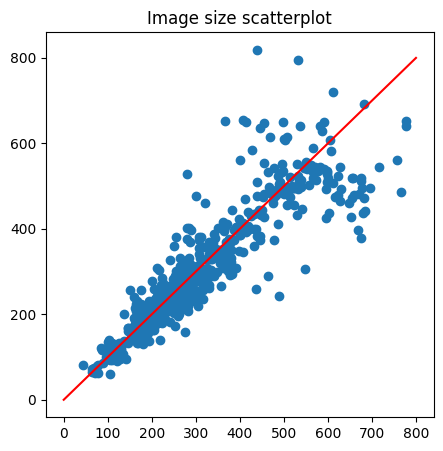

In [17]:
size = [cv2.imread(root_path+ name).shape for name in os.listdir(root_path)]
x, y, _ = zip(*size)

fig = plt.figure(figsize=(5, 5))
# scatter plot
plt.scatter(x,y)
plt.title("Image size scatterplot")

# add diagonal red line 
plt.plot([0,800],[0,800], 'r')

**Data Preprocessing**

In [18]:
def process_img(img, size = (128,128)):
    img = cv2.resize(img, size)  # resize image
    img = img/255                   # devide values to 255
    return img

In [19]:
# Read all images and put in X variable, Y variable is class names
X, Y = [], []
for name  in os.listdir(root_path):
    img = cv2.imread(root_path + name)
    X.append(process_img(img))
    Y.append(name.replace(' ', '_').split('_')[0])

X = np.array(X)

In [21]:
num_images = len(X)
print("Number of images in X:", num_images)


Number of images in X: 790


In [22]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

le = LabelEncoder()
Y_le = le.fit_transform(Y)
Y_cat = np_utils.to_categorical(Y_le, 23)

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y_cat, test_size=0.285, stratify=Y_le)
print("Images in each class in Test set: {}".format(np.sum(Y_test, axis =0)))

Images in each class in Test set: [ 6. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10.]


**Model Building**

In [24]:
input_shape =  X_train[0].shape
output_shape = 23

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3, input_shape = input_shape, activation= 'relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 32, kernel_size = 2, activation= 'relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 64, kernel_size = 2, activation= 'relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 128, kernel_size = 2, activation= 'relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(500, activation = 'relu'))
# model.add(Dropout(0.2))
model.add(Dense(150, activation = 'relu'))
# model.add(Dropout(0.2))
model.add(Dense(output_shape, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [25]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
print('Model is Compiled!')

Model is Compiled!


In [26]:
datagener = ImageDataGenerator(
                rotation_range= 20,
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                horizontal_flip = True,
                vertical_flip = True,)
# fit data generator
datagener.fit(X_train)

In [27]:
batch_size = 4
epochs = 500

model_path = 'cnn.hdf5'
callbecks = [EarlyStopping(monitor ='val_loss', patience = 20), 
             ModelCheckpoint(filepath = model_path, save_best_only = True)]


history = model.fit(
        datagener.flow(X_train, Y_train, batch_size=batch_size), 
        batch_size = batch_size, 
        steps_per_epoch = len(X_train) // batch_size,
        epochs = epochs,
        validation_data = (X_train, Y_train),
        callbacks = callbecks,
        verbose = 1)

Epoch 1/500
141/141 [==============================] - 15s 23ms/step - loss: 3.1665 - accuracy: 0.0319 - val_loss: 3.1346 - val_accuracy: 0.0443
Epoch 2/500
141/141 [==============================] - 3s 23ms/step - loss: 3.1240 - accuracy: 0.0355 - val_loss: 3.0714 - val_accuracy: 0.0550
Epoch 3/500
141/141 [==============================] - 3s 20ms/step - loss: 2.9035 - accuracy: 0.0745 - val_loss: 2.6493 - val_accuracy: 0.1241
Epoch 4/500
141/141 [==============================] - 3s 20ms/step - loss: 2.7433 - accuracy: 0.0798 - val_loss: 2.6438 - val_accuracy: 0.1277
Epoch 5/500
141/141 [==============================] - 3s 22ms/step - loss: 2.6538 - accuracy: 0.1418 - val_loss: 2.3510 - val_accuracy: 0.2039
Epoch 6/500
141/141 [==============================] - 4s 31ms/step - loss: 2.5584 - accuracy: 0.1489 - val_loss: 2.4967 - val_accuracy: 0.1862
Epoch 7/500
141/141 [==============================] - 3s 23ms/step - loss: 2.4664 - accuracy: 0.1472 - val_loss: 2.1224 - val_accuracy

In [28]:
model.load_weights(model_path)
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test set accuracy: {}'.format(score[1]))

Test set accuracy: 0.8141592741012573


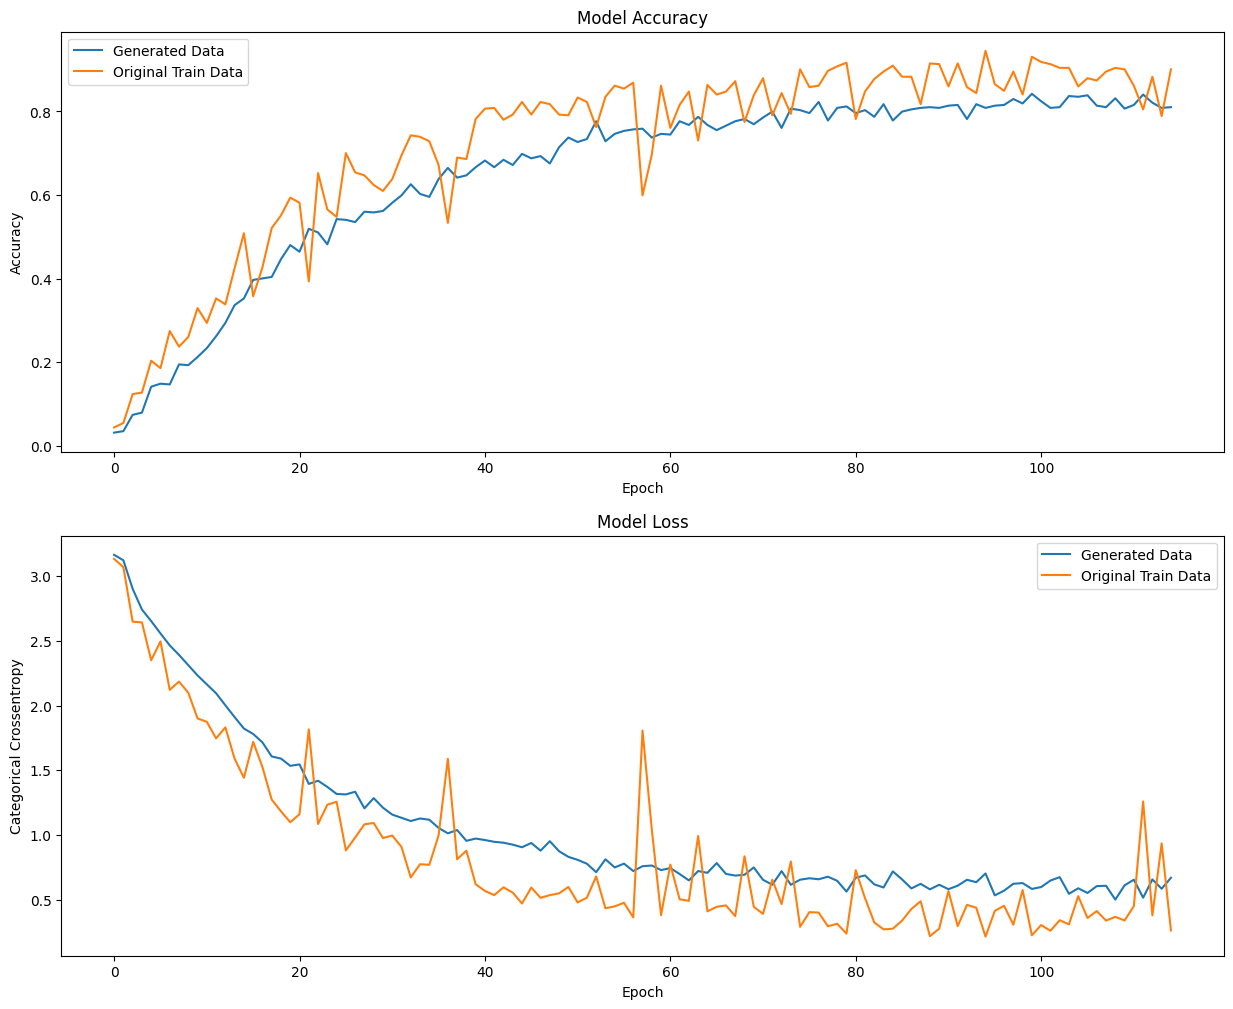

In [29]:
plt.figure(figsize = (15,12))     
   
plt.subplot(211)  
plt.title('Model Accuracy')  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Generated Data', 'Original Train Data'], loc='best')  
      
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Categorical Crossentropy')  
plt.xlabel('Epoch')  
plt.legend(['Generated Data', 'Original Train Data'], loc='best')  
plt.show()

**Save, Load and Test the Model**

In [30]:
model.save("model.h5")

In [66]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model= load_model("model.h5")
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from keras.applications.vgg16 import preprocess_input
# Load image and resize
img = load_img('drive/MyDrive/Colab Notebooks/data/urochloa (35).jpg',target_size=(128,128))
img = img.resize((128, 128))
# Convert to array and preprocess
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
# Predict
a = np.argmax(model.predict(x), axis=1)
index = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']
result =str( index[a[0]])
result

1/1 [==============================] - 0s 135ms/step


'22'

In [55]:
op = ['arecaceae', 'anadenanthera', 'arrabidaea', 'cecropia', 'chromolaena', 'combretum', 'croton', 'dipteryx', 'eucalipto', 'faramea', 'hyptis', 'mabea', 'matayba', 'mimosa', 'myrcia', 'protium', 'qualea', 'schinus', 'senegalia', 'serjania', 'syagrus', 'tridax', 'urochloa']
result = op[a[0]]
print(result)

urochloa


In [57]:
# Load image and resize
img = load_img('drive/MyDrive/Colab Notebooks/data/eucalipto_23.jpg',target_size=(128,128))
img = img.resize((128, 128))
# Convert to array and preprocess
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
# Predict
a = np.argmax(model.predict(x), axis=1)
index = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']
result =str( index[a[0]])
result
op = ['arecaceae', 'anadenanthera', 'arrabidaea', 'cecropia', 'chromolaena', 'combretum', 'croton', 'dipteryx', 'eucalipto', 'faramea', 'hyptis', 'mabea', 'matayba', 'mimosa', 'myrcia', 'protium', 'qualea', 'schinus', 'senegalia', 'serjania', 'syagrus', 'tridax', 'urochloa']
result = op[a[0]]
print(result)

1/1 [==============================] - 0s 28ms/step
eucalipto


In [71]:
# Load image and resize
img = load_img('drive/MyDrive/Colab Notebooks/data/croton_23.jpg',target_size=(128,128))
img = img.resize((128, 128))
# Convert to array and preprocess
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
# Predict
a = np.argmax(model.predict(x), axis=1)
index = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']
result =str( index[a[0]])
result
op = ['arecaceae', 'anadenanthera', 'arrabidaea', 'cecropia', 'chromolaena', 'combretum', 'croton', 'dipteryx', 'eucalipto', 'faramea', 'hyptis', 'mabea', 'matayba', 'mimosa', 'myrcia', 'protium', 'qualea', 'schinus', 'senegalia', 'serjania', 'syagrus', 'tridax', 'urochloa']
result = op[a[0]]
print(result)

1/1 [==============================] - 0s 55ms/step
croton


In [72]:
# Load image and resize
img = load_img('drive/MyDrive/Colab Notebooks/data/hyptis_23.jpg',target_size=(128,128))
img = img.resize((128, 128))
# Convert to array and preprocess
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
# Predict
a = np.argmax(model.predict(x), axis=1)
index = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']
result =str( index[a[0]])
result
op = ['arecaceae', 'anadenanthera', 'arrabidaea', 'cecropia', 'chromolaena', 'combretum', 'croton', 'dipteryx', 'eucalipto', 'faramea', 'hyptis', 'mabea', 'matayba', 'mimosa', 'myrcia', 'protium', 'qualea', 'schinus', 'senegalia', 'serjania', 'syagrus', 'tridax', 'urochloa']
result = op[a[0]]
print(result)

1/1 [==============================] - 0s 135ms/step
hyptis
